<a href="https://colab.research.google.com/github/aIacoella/ANNDL-HW1/blob/dataset_filtering/Upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu = False

if gpu:
  from numba import cuda
  device = cuda.get_current_device()
  device.reset()

In [2]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [5]:
# Utility functions

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

def split_image(img, upscale_factor):
    height = img.shape[0] // upscale_factor
    width = img.shape[1] // upscale_factor
    z = img.shape[2]

    img11 = tf.slice(img, [0, 0, 0], [height, width, z])
    img12 = tf.slice(img, [0, width, 0], [height, width, z])
    img13 = tf.slice(img, [0, width*2, 0], [height, width, z])
    img21 = tf.slice(img, [height, 0, 0], [height, width, z])
    img22 = tf.slice(img, [height, width, 0], [height, width, z])
    img23 = tf.slice(img, [height, width*2, 0], [height, width, z])
    img31 = tf.slice(img, [height*2, 0, 0], [height, width, z])
    img32 = tf.slice(img, [height*2, width, 0], [height, width, z])
    img33 = tf.slice(img, [height*2, width*2, 0], [height, width, z])

    return [img11, img12, img13, img21, img22, img23, img31, img32, img33]

def plot_results(imgs, titles):

    # Create a new figure with a default 111 subplot.
    fig, axes = plt.subplots(1, len(imgs))
    for ax, img, title in zip(axes, imgs, titles):
        img_array = img_to_array(img)
        img_array = img_array.astype("float32") / 255.0
        ax.imshow(img_array[::-1], origin="lower")
        ax.axis('off')

    """
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    """
    plt.tight_layout()
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def load_data(seed=42, path="./public_data.npz", data=None, test_size=0.2, val_size=0.2):
    np.random.seed(seed)
    if path is not None:
        data_file = np.load(path, allow_pickle=True)
    else:
        data_file = data
    data = data_file["data"]
    y = data_file["labels"]
    y[y == "healthy"] = 0
    y[y == "unhealthy"] = 1
    y = y.astype(np.float32)

    #Trolls
    troll = data[338]
    shrek = data[58]

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(troll / 255)
    axes[1].imshow(shrek / 255)
    plt.tight_layout()
    plt.show()

    print("Removing trolls, shreks and duplicates")
    initialDataN = data.shape[0]

    mask = []
    for i in range(data.shape[0]):
        if np.array_equal(data[i], troll) or np.array_equal(data[i], shrek):
            mask.append(False)
        else:
            mask.append(True)

    data = data[mask]
    y = y[mask]

    data, indexes = np.unique(data, axis=0, return_index=True)
    y = y[indexes]

    print("Removed Images: " + str(initialDataN - data.shape[0]))

    if(test_size==0 and val_size==0):
        return (data, y), None, None

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        data, y, random_state=seed, test_size=test_size, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, random_state=seed, test_size=val_size, stratify=y_train_val)

    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

In [6]:
# Load data

crop_size = 96
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/

data_file = np.load("./public_data.npz", allow_pickle=True)
data = data_file["data"]

train_ds = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [7]:
# Upscaling model

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [8]:
# Define callbacks

"""
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))
"""

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [early_stopping_callback, model_checkpoint_callback]  #ESPCNCallback(),
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOp  (None, None, None, 1)     0         
 Lambda)                                                         
                                                             

In [9]:
# Train model

epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/100
650/650 - 23s - loss: 0.0047 - val_loss: 0.0020 - 23s/epoch - 35ms/step
Epoch 2/100
650/650 - 5s - loss: 0.0019 - val_loss: 0.0019 - 5s/epoch - 8ms/step
Epoch 3/100
650/650 - 5s - loss: 0.0018 - val_loss: 0.0018 - 5s/epoch - 8ms/step
Epoch 4/100
650/650 - 6s - loss: 0.0018 - val_loss: 0.0018 - 6s/epoch - 9ms/step
Epoch 5/100
650/650 - 5s - loss: 0.0018 - val_loss: 0.0017 - 5s/epoch - 8ms/step
Epoch 6/100
650/650 - 5s - loss: 0.0017 - val_loss: 0.0017 - 5s/epoch - 8ms/step
Epoch 7/100
650/650 - 5s - loss: 0.0017 - val_loss: 0.0016 - 5s/epoch - 8ms/step
Epoch 8/100
650/650 - 4s - loss: 0.0016 - val_loss: 0.0016 - 4s/epoch - 7ms/step
Epoch 9/100
650/650 - 5s - loss: 0.0016 - val_loss: 0.0016 - 5s/epoch - 8ms/step
Epoch 10/100
650/650 - 5s - loss: 0.0016 - val_loss: 0.0016 - 5s/epoch - 7ms/step
Epoch 11/100
650/650 - 9s - loss: 0.0016 - val_loss: 0.0016 - 9s/epoch - 13ms/step
Epoch 12/100
650/650 - 4s - loss: 0.0016 - val_loss: 0.0015 - 4s/epoch - 7ms/step
Epoch 13/100
650/650 

1/1 [==============================] - 0s 237ms/step
PSNR of low resolution image and high resolution image is 27.7824
PSNR of predict and high resolution is 30.0026


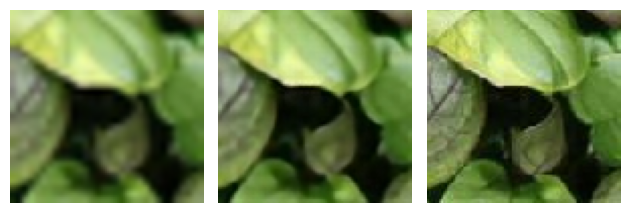

1/1 [==============================] - 0s 30ms/step
PSNR of low resolution image and high resolution image is 23.6601
PSNR of predict and high resolution is 24.9408


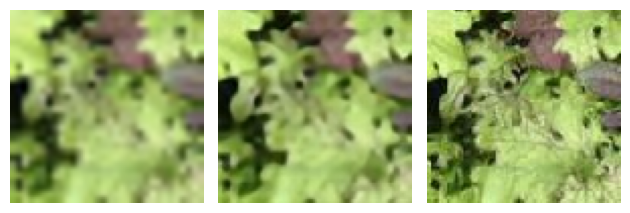

1/1 [==============================] - 0s 25ms/step
PSNR of low resolution image and high resolution image is 25.4097
PSNR of predict and high resolution is 27.5651


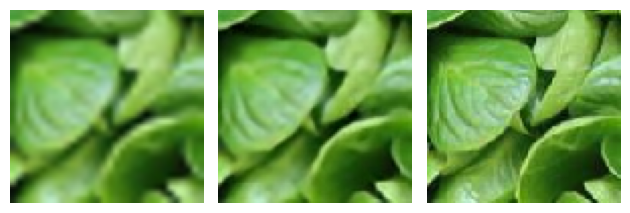

1/1 [==============================] - 0s 32ms/step
PSNR of low resolution image and high resolution image is 26.1018
PSNR of predict and high resolution is 26.7780


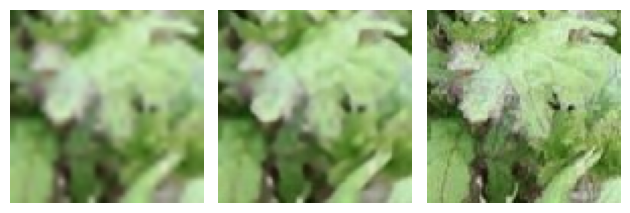

1/1 [==============================] - 0s 26ms/step
PSNR of low resolution image and high resolution image is 27.6071
PSNR of predict and high resolution is 29.5144


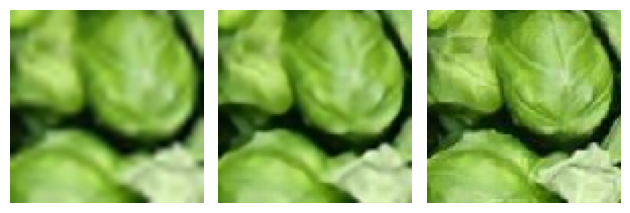

1/1 [==============================] - 0s 39ms/step
PSNR of low resolution image and high resolution image is 27.1327
PSNR of predict and high resolution is 29.6474


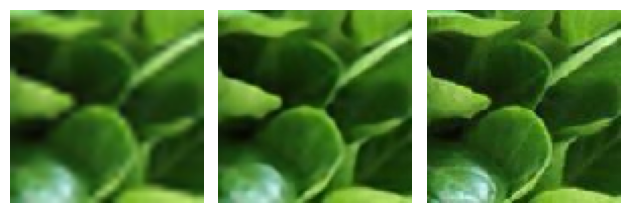

1/1 [==============================] - 0s 23ms/step
PSNR of low resolution image and high resolution image is 26.3720
PSNR of predict and high resolution is 28.1390


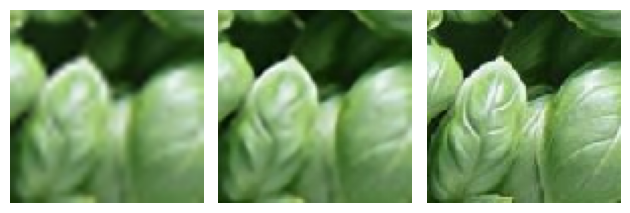

1/1 [==============================] - 0s 30ms/step
PSNR of low resolution image and high resolution image is 23.8174
PSNR of predict and high resolution is 25.4156


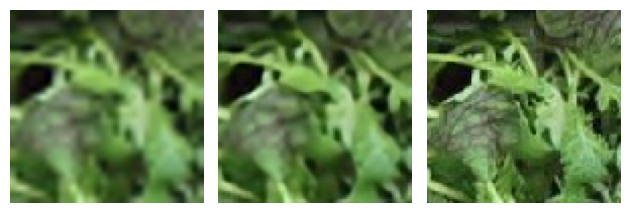

1/1 [==============================] - 0s 25ms/step
PSNR of low resolution image and high resolution image is 25.1621
PSNR of predict and high resolution is 27.6169


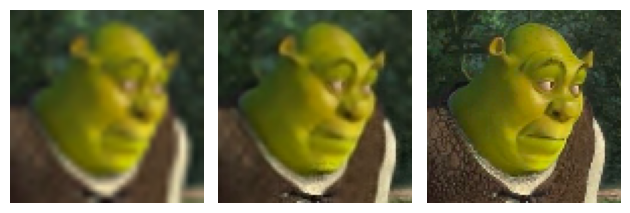

1/1 [==============================] - 0s 30ms/step
PSNR of low resolution image and high resolution image is 29.2985
PSNR of predict and high resolution is 31.1987


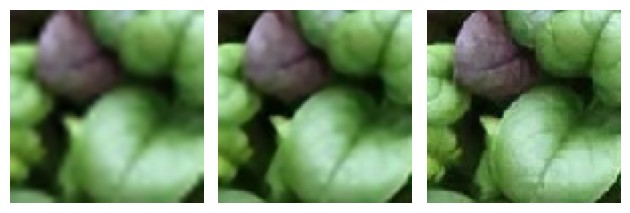

Avg. PSNR of lowres images is 26.2344
Avg. PSNR of reconstructions is 28.0818


In [10]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img in enumerate(data[50:60]):
    img = array_to_img(test_img)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results([lowres_img, prediction, highres_img], ["lowres", "prediction", "highres"])

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

1/1 [==============================] - 0s 218ms/step


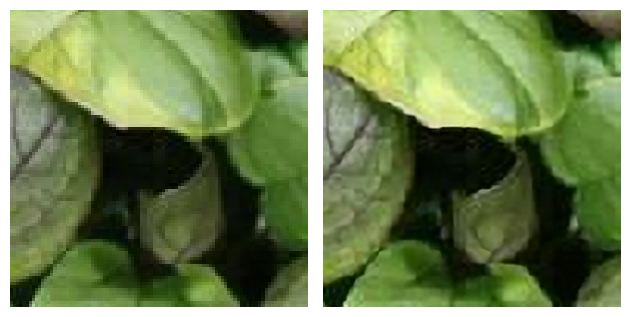

1/1 [==============================] - 0s 17ms/step


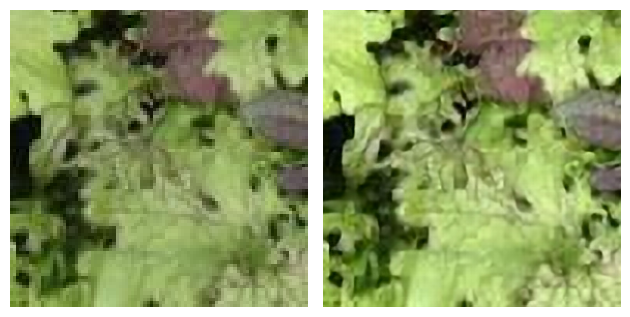

1/1 [==============================] - 0s 18ms/step


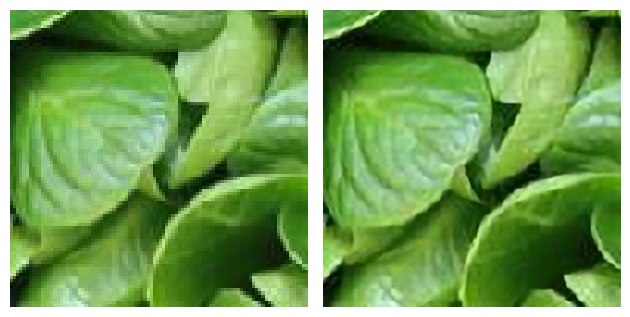

1/1 [==============================] - 0s 18ms/step


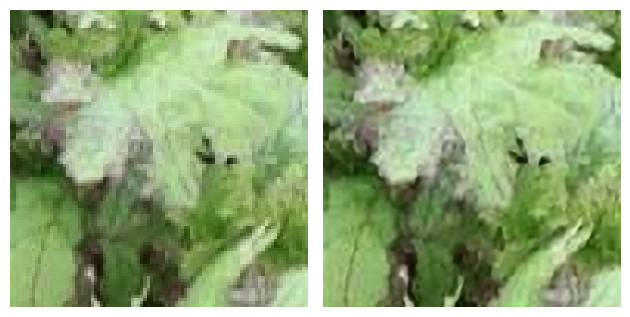

1/1 [==============================] - 0s 20ms/step


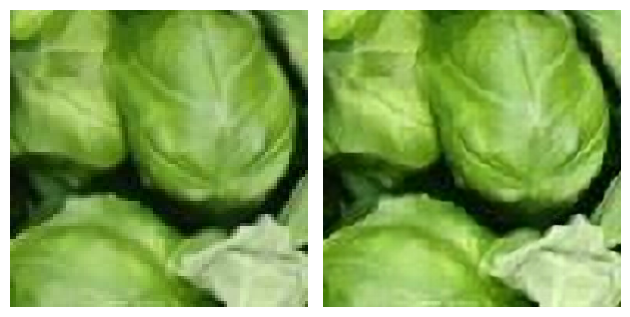

1/1 [==============================] - 0s 19ms/step


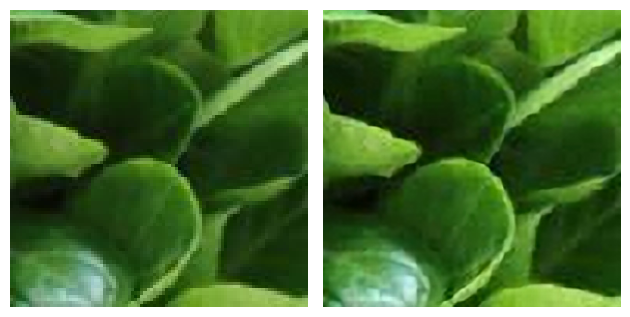

1/1 [==============================] - 0s 20ms/step


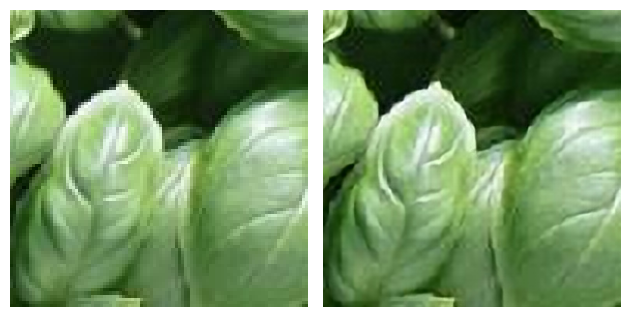

1/1 [==============================] - 0s 17ms/step


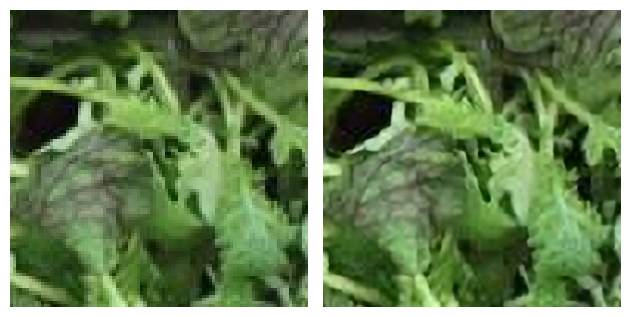

1/1 [==============================] - 0s 17ms/step


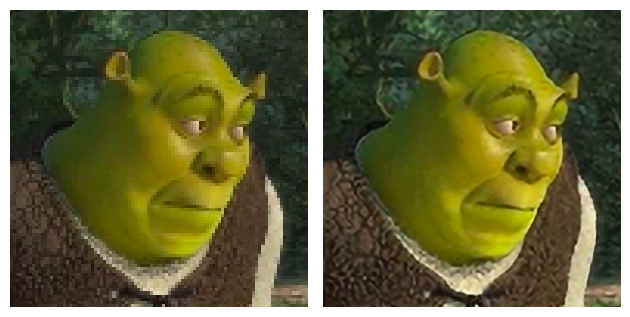

1/1 [==============================] - 0s 24ms/step


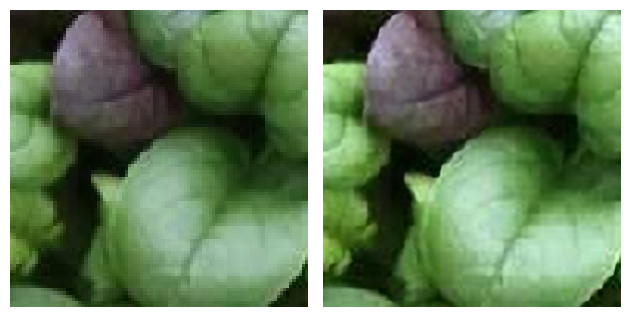

In [11]:
# Show images

def upscale_big_image(model, img):
    height = img.shape[0] // upscale_factor
    width = img.shape[1] // upscale_factor
    z = img.shape[2]

    img11 = tf.slice(img, [0, 0, 0], [height, width, z])
    img12 = tf.slice(img, [0, width, 0], [height, width, z])
    img13 = tf.slice(img, [0, width*2, 0], [height, width, z])
    img21 = tf.slice(img, [height, 0, 0], [height, width, z])
    img22 = tf.slice(img, [height, width, 0], [height, width, z])
    img23 = tf.slice(img, [height, width*2, 0], [height, width, z])
    img31 = tf.slice(img, [height*2, 0, 0], [height, width, z])
    img32 = tf.slice(img, [height*2, width, 0], [height, width, z])
    img33 = tf.slice(img, [height*2, width*2, 0], [height, width, z])

    sub_images = [img11, img12, img13, img21, img22, img23, img31, img32, img33]

    predicted_sub_img = []
    for simg in sub_images:
        simg = array_to_img(simg)
        simg = simg.resize((height * upscale_factor, width * upscale_factor), PIL.Image.BICUBIC)
        predicted_sub_img.append(upscale_image(model, simg))

    predicted = tf.concat([tf.concat(predicted_sub_img[0:3], axis=1),
                      tf.concat(predicted_sub_img[3:6], axis=1),
                      tf.concat(predicted_sub_img[6:9], axis=1)],
                      axis=0)
    return array_to_img(predicted)

for index, test_img in enumerate(data[50:60]):
    img = array_to_img(test_img)
    prediction = upscale_image(model, img)
    predict_img_arr = img_to_array(prediction)
    plot_results([test_img, predict_img_arr], ["img", "prediction"])


In [ ]:
# rescale everything

upscaled_data = []
for img in data:
    upscaled_data.append(upscale_big_image(model, img))

plt.imshow(data[0] / 255)

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 31ms/step


In [ ]:
# Load data

data_file["data"] = upscaled_data
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data(path=None, data=data_file)
X_train.shape

In [ ]:
batch_size = 16
epochs = 100

In [ ]:
model = tfk.applications.Xception(
    input_shape=(288, 288, 3),
    include_top=False,
    weights="imagenet",
)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomRotation(0.1),
])

In [ ]:
model.trainable = False

inputs = tfk.Input(shape=(288, 288, 3))

x = data_augmentation(inputs)
scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
x = scale_layer(x)

x = model(x, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)

output = tfkl.Dense(1)(x)
model = tfk.Model(inputs, output, name="modelAugX")
model.compile(
    loss=tfk.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tfk.optimizers.Adam(),
    metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall(), tfk.metrics.TruePositives(), tfk.metrics.TrueNegatives(), tfk.metrics.FalsePositives(), tfk.metrics.FalseNegatives()])
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = batch_size,
    epochs = 100,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history